## Text-Mining-Project-US-EU-Diplomatic-Communications-2013-2015

## Dictionary & corpus based

**Introduction: Corpus-based topic modeling with LDA**


**Main Assumption**


2. Data & preprocessing
3. Dictionary and corpus construction
4. LDA model and topic selection
5. Topic interpretation
6. EU vs non-EU comparison

## **1. Import Libraries**

**Code test on Python(.venv)3.12.4**

In [1]:
## Import libraries
#! python -m spacy download en_core_web_sm
#! pip install sapcy

# Core data and NLP
from pathlib import Path
import os
import pandas as pd
import numpy as np
import spacy

# Topic modeling
import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel, CoherenceModel

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.corpora import Dictionary


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/runpy.py", line 88, in _run_code
    exec(code, run_globals)
  File "/Users/ninalin/Desktop/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/ninalin/Desktop/.venv/lib/python3.12/site-packages/traitlets/config/appl


## **2. Import Data**
  
**Reuse the same preprocessed text chunks as in the BERTopic analysis for comparability.**
   

In [ ]:
## Check work_dir

os.listdir(".")

CWD = os.getcwd()
PROJECT_ROOT = os.path.dirname(CWD)
CLEAN_DIR = os.path.join(PROJECT_ROOT, "clean")

print("CWD:", CWD)
print("PROJECT_ROOT:", PROJECT_ROOT)
print("CLEAN_DIR:", CLEAN_DIR)
PROJECT_ROOT = Path.cwd().parent

for p in PROJECT_ROOT.rglob("*.parquet"):
    print(p)

CWD: /Users/ninalin/Desktop/dsba/winter semester 25/text mining/project/Text-Mining-Project-US-EU-Diplomatic-Communications-2013-2015-/notebook
PROJECT_ROOT: /Users/ninalin/Desktop/dsba/winter semester 25/text mining/project/Text-Mining-Project-US-EU-Diplomatic-Communications-2013-2015-
CLEAN_DIR: /Users/ninalin/Desktop/dsba/winter semester 25/text mining/project/Text-Mining-Project-US-EU-Diplomatic-Communications-2013-2015-/clean
/Users/ninalin/Desktop/dsba/winter semester 25/text mining/project/Text-Mining-Project-US-EU-Diplomatic-Communications-2013-2015-/dataset /clean/corpus_chunks_2013_2015.parquet


In [ ]:
## Import Data

PROJECT_ROOT = Path.cwd().parent

df = pd.read_parquet(
    PROJECT_ROOT / "dataset " / "clean" / "corpus_chunks_2013_2015.parquet"
)
df.shape, df.head()

((26785, 7),
    year      country  is_eu            section      source_file  \
 0  2013  Afghanistan  False  EXECUTIVE SUMMARY  Afghanistan.txt   
 1  2013  Afghanistan  False         Section 1.  Afghanistan.txt   
 2  2013  Afghanistan  False         Section 1.  Afghanistan.txt   
 3  2013  Afghanistan  False         Section 1.  Afghanistan.txt   
 4  2013  Afghanistan  False         Section 1.  Afghanistan.txt   
 
                                 chunk_id  \
 0  Afghanistan.txt::EXECUTIVE SUMMARY::0   
 1         Afghanistan.txt::Section 1.::0   
 2         Afghanistan.txt::Section 1.::1   
 3         Afghanistan.txt::Section 1.::2   
 4         Afghanistan.txt::Section 1.::3   
 
                                                 text  
 0  Share Afghanistan is an Islamic republic with ...  
 1  Respect for the Integrity of the Person, Inclu...  
 2  judges, prosecutors, and clerical staff. In Ju...  
 3  were reports that insurgent groups were respon...  
 4  with fists and electr

In [4]:
# Preprocess 
df = df.copy()

df["year"] = df["year"].astype(int)
assert df["text"].str.strip().eq("").sum() == 0

## **3. Corpus-base**

>All documents processed using the **spaCy NLP pipeline**.
>
>The preprocessing steps included **tokenization, lemmatization, lowercasing**, and the **removal of stopwords** and **non-alphabetic tokens**.
>
>Only tokens with a minimum length of three characters were retained.
>
>As a result, each document was represented as a list of cleaned and lemmatized tokens.

In [5]:
## Load spacy

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

## Process function
def preprocess(text):
    doc = nlp(text)
    tokens = [
        token.lemma_.lower()
        for token in doc
        if token.is_alpha
        and not token.is_stop
        and len(token) > 2
    ]
    return tokens

In [6]:
## Apply data and Inspection

df["tokens"] = df["text"].apply(preprocess)
print(df["tokens"].head())

0    [share, afghanistan, islamic, republic, strong...
1    [respect, integrity, person, include, freedom,...
2    [judge, prosecutor, clerical, staff, june, tal...
3    [report, insurgent, group, responsible, disapp...
4    [fist, electric, cable, kicking, choke, electr...
Name: tokens, dtype: object


In [7]:
## Dictionary

dictionary = Dictionary(df["tokens"])
print(len(dictionary))

## Remove extremely rare word,
dictionary.filter_extremes(
    no_below=10,   
    no_above=0.5  
)
print(len(dictionary))

42107
9490


>A dictionary was constructed from the preprocessed tokens.
>
>Extremely rare and overly frequent terms were removed by retaining only tokens that appeared in at least 10 documents and in no more than 50% of the corpus.
>
>After filtering, the dictionary size was reduced from 42107 to 9490 unique tokens."

## **4. Bag of word corpus**

In [8]:
## BoW
corpus = [dictionary.doc2bow(tokens) for tokens in df["tokens"]]
corpus[0][:10]

[(0, 8),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1)]

Converted document into a bag-of-words representation based on the filtered dictionary, where each document is represented as a list of (token_id, frequency) pairs.

In [9]:
## Saved dictionary and corpus

dictionary.save("lda_dictionary.dict")
gensim.corpora.MmCorpus.serialize("lda_corpus.mm", corpus)
   

## **5. Coherence Sweep**

In [10]:
## Coherence function

def compute_coherence_values(dictionary, corpus, texts, k_values):
    coherence_scores = []
    models = {}

    for k in k_values:
        print(f"Training LDA with K={k}")
        lda = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=k,
            random_state=42,
            passes=10,
            alpha="auto",
            eta="auto"
        )
        models[k] = lda

        coherence = CoherenceModel(
            model=lda,
            texts=texts,
            dictionary=dictionary,
            coherence="c_v"
        ).get_coherence()

        coherence_scores.append(coherence)

    return models, coherence_scores
   

In [11]:
## K range
k_values = list(range(5, 21, 2))  # 5,7,9,...,19

lda_models, coherence_scores = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=df["tokens"],
    k_values=k_values
)

Training LDA with K=5
Training LDA with K=7
Training LDA with K=9
Training LDA with K=11
Training LDA with K=13
Training LDA with K=15
Training LDA with K=17
Training LDA with K=19


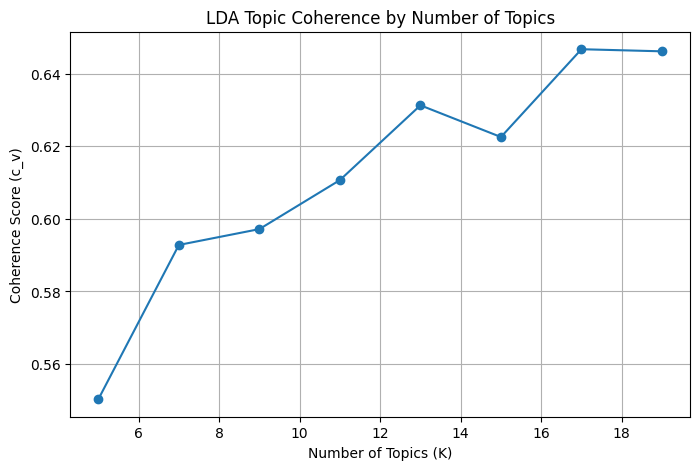

In [12]:
## K

best_k = k_values[coherence_scores.index(max(coherence_scores))]
best_k

plt.figure(figsize=(8, 5))
plt.plot(k_values, coherence_scores, marker="o")
plt.xlabel("Number of Topics (K)")
plt.ylabel("Coherence Score (c_v)")
plt.title("LDA Topic Coherence by Number of Topics")
plt.grid(True)
plt.show()

In [13]:
## LDA model

final_k = best_k 
lda_model = lda_models[final_k]

for topic_id, topic_words in lda_model.print_topics(num_words=10):
    print(f"Topic {topic_id}: {topic_words}")

Topic 0: 0.040*"worker" + 0.029*"work" + 0.024*"labor" + 0.023*"hour" + 0.022*"wage" + 0.017*"sector" + 0.016*"safety" + 0.016*"health" + 0.016*"employer" + 0.016*"pay"
Topic 1: 0.036*"police" + 0.025*"force" + 0.019*"security" + 0.012*"arrest" + 0.009*"torture" + 0.009*"military" + 0.009*"member" + 0.009*"kill" + 0.008*"group" + 0.008*"officer"
Topic 2: 0.039*"refugee" + 0.029*"country" + 0.025*"asylum" + 0.018*"person" + 0.017*"protection" + 0.014*"seeker" + 0.013*"unhcr" + 0.011*"travel" + 0.010*"status" + 0.010*"movement"
Topic 3: 0.044*"public" + 0.038*"information" + 0.022*"official" + 0.021*"access" + 0.020*"require" + 0.015*"financial" + 0.013*"disclosure" + 0.012*"request" + 0.009*"state" + 0.008*"asset"
Topic 4: 0.048*"election" + 0.038*"political" + 0.036*"party" + 0.016*"member" + 0.014*"woman" + 0.013*"president" + 0.013*"participation" + 0.012*"national" + 0.012*"opposition" + 0.011*"parliament"
Topic 5: 0.034*"freedom" + 0.019*"medium" + 0.016*"journalist" + 0.014*"inter

## **6. Automatic Topic Generation**

In [14]:
## Domain Topic

def get_dominant_topic(lda_model, bow, min_prob=0.0):
    topics = lda_model.get_document_topics(bow, minimum_probability=min_prob)
    if not topics:
        return -1
    return max(topics, key=lambda x: x[1])[0]

In [15]:
## Save topic to df

df["topic"] = [
    get_dominant_topic(lda_model, bow)
    for bow in corpus]

In [16]:
## Topic Index Range Validation
assert df["topic"].max() < lda_model.num_topics
assert df["topic"].min() >= -1

In [17]:
## Topic label

def auto_topic_label(lda_model, topic_id, topn=5):
    words = [w for w, _ in lda_model.show_topic(topic_id, topn)]
    return " / ".join(words[:2])

topic_labels_auto = {
    t: auto_topic_label(lda_model, t)
    for t in range(lda_model.num_topics)
}

df["topic_label_auto"] = (
    df["topic"]
    .map(topic_labels_auto)
    .fillna("outlier")
)

print(df[["topic", "topic_label_auto"]].drop_duplicates().sort_values("topic"))

    topic         topic_label_auto
75      0            worker / work
1       1           police / force
33      2        refugee / country
46      3     public / information
36      4     election / political
27      5         freedom / medium
59      6            woman / child
0       7           human / rights
18      8        corruption / case
12      9             court / case
16     10         violence / woman
68     11      disability / person
73     12            labor / child
6      13        prison / prisoner
72     14           union / worker
57     15              child / age
70     16  discrimination / person


### **6.1 Model Quality Evaluation**

In [18]:
## Topic Diversity

def topic_diversity(topics, top_n=10):
    words = [w for topic in topics for w in topic[:top_n]]
    return len(set(words)) / len(words)

topics = [
    [word for word, _ in lda_model.show_topic(topic_id, topn=10)]
    for topic_id in range(lda_model.num_topics)
]
td_score = topic_diversity(topics, top_n=10)
print(td_score)

0.7352941176470589


In [19]:
## Topic distribution

topic_distributions = [
    lda_model.get_document_topics(bow, minimum_probability=0)
    for bow in corpus
]

### **6.2 Concate to full data**

In [20]:
## DF format

topic_df = pd.DataFrame(
    [
        {f"topic_{topic_id}": prob for topic_id, prob in doc_topics}
        for doc_topics in topic_distributions
    ]
)

print(topic_df.head())
print(topic_df.shape)

    topic_0   topic_1   topic_2   topic_3   topic_4   topic_5   topic_6  \
0  0.000396  0.143562  0.000436  0.000570  0.086135  0.015481  0.000515   
1  0.000447  0.825114  0.000492  0.000643  0.017148  0.000630  0.052229   
2  0.041775  0.895650  0.000510  0.000666  0.000492  0.000653  0.000601   
3  0.000407  0.849760  0.000448  0.000585  0.000433  0.000574  0.000529   
4  0.000461  0.584525  0.000507  0.000663  0.000490  0.000650  0.000598   

    topic_7   topic_8   topic_9  topic_10  topic_11  topic_12  topic_13  \
0  0.402710  0.038127  0.000661  0.097609  0.000334  0.014054  0.035430   
1  0.067381  0.031819  0.000746  0.000497  0.000377  0.000425  0.000520   
2  0.000824  0.000852  0.043735  0.000515  0.000391  0.000440  0.000538   
3  0.000725  0.028032  0.000679  0.000453  0.000344  0.000387  0.097002   
4  0.000821  0.083314  0.006957  0.000513  0.000389  0.000438  0.248855   

   topic_14  topic_15  topic_16  
0  0.000301  0.049819  0.113860  
1  0.000340  0.000520  0.00067

In [21]:
## Concat to cleaned data

df_topics = pd.concat(
    [df.reset_index(drop=True), topic_df.reset_index(drop=True)],
    axis=1
)
## Sanitary Check
topic_prob_cols = [
    c for c in df_topics.columns
    if c.startswith("topic_") and c.split("_")[1].isdigit()
]

df_topics[topic_prob_cols].sum(axis=1).head()


0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
dtype: float32

## **7. Topic-Based Analysis**

In [22]:
## Group EU and non-EU countries

topic_prob_cols = [
    c for c in df_topics.columns
    if c.startswith("topic_") and c.split("_")[1].isdigit()
]

eu_mean = df_topics[df_topics["is_eu"]][topic_prob_cols].mean()
noneu_mean = df_topics[~df_topics["is_eu"]][topic_prob_cols].mean()


In [23]:
## Calculate difference

comparison_df = pd.DataFrame({
    "EU": eu_mean,
    "Non_EU": noneu_mean,
    "Difference (EU - Non_EU)": eu_mean - noneu_mean
})

comparison_df.sort_values("Difference (EU - Non_EU)", ascending=False)

,EU,Non_EU,Difference (EU - Non_EU)
topic_16,0.086326,0.048931,0.037395
topic_11,0.056291,0.037010,0.019281
topic_2,0.076592,0.059956,0.016636
topic_3,0.050657,0.035950,0.014707
topic_10,0.067197,0.052511,0.014686
topic_13,0.076130,0.063319,0.012811
topic_0,0.064744,0.055331,0.009412
topic_9,0.097110,0.095002,0.002107
topic_7,0.052461,0.054998,-0.002537
topic_15,0.044983,0.047730,-0.002747


>To examine differences, documents were grouped by EU and non-EU countries, calculate the average topic proportions to compared across topics.
>
>EU diplomatic communications place greater emphasis on identity-based and intersectional forms of discrimination.
>
>Judicial Process & Fair Trial are equally important in both EU and non EU countries"

In [24]:
## Yearly Difference

topic_cols = [
    c for c in df_topics.columns
    if c.startswith("topic_") and c.split("_")[1].isdigit()
]

yearly_topics = (
    df_topics
    .groupby("year")[topic_cols]
    .mean()
    .sort_index()
)

print(yearly_topics)

       topic_0   topic_1   topic_2   topic_3   topic_4   topic_5   topic_6  \
year                                                                         
2013  0.054351  0.099886  0.060114  0.039364  0.050276  0.077396  0.059625   
2014  0.055906  0.099717  0.059206  0.037189  0.049389  0.077641  0.060699   
2015  0.058644  0.099956  0.065788  0.035871  0.046307  0.080084  0.060971   

       topic_7   topic_8   topic_9  topic_10  topic_11  topic_12  topic_13  \
year                                                                         
2013  0.056041  0.069844  0.096595  0.052861  0.038780  0.038862  0.067383   
2014  0.054158  0.067374  0.093769  0.054400  0.038736  0.041533  0.067874   
2015  0.054051  0.063077  0.095376  0.054778  0.039479  0.043904  0.058527   

      topic_14  topic_15  topic_16  
year                                
2013  0.042371  0.045893  0.050357  
2014  0.039994  0.048645  0.053769  
2015  0.041312  0.047731  0.054144  


>Issues related to gender-based violence increase over time,
>
>Corruption is treated as a serious structural issue rather than a time-sensitive topic.

In [25]:
## Year Topic comparison

def topic_share_by_year(df_sub, label):
    t = (
        df_sub[df_sub["topic"] != -1]
        .groupby(["year", "topic"])
        .size()
        .reset_index(name="n")
    )
    t["share"] = t["n"] / t.groupby("year")["n"].transform("sum")
    t["group"] = label
    return t
eu_year = topic_share_by_year(df[df["is_eu"]], "EU")

pivot = eu_year.pivot_table(
    index="topic",
    columns="year",
    values="share",
    fill_value=0.0
)

years = sorted(pivot.columns.tolist())
pivot["delta_first_to_last"] = pivot[years[-1]] - pivot[years[0]]
out = (
    pivot
    .sort_values("delta_first_to_last", ascending=False)
    .head(10)
    .copy()
)
def auto_topic_label(lda_model, topic_id, topn=5):
    words = [w for w, _ in lda_model.show_topic(topic_id, topn)]
    return " / ".join(words[:2])

out["topic_name"] = out.index.map(
    lambda t: auto_topic_label(lda_model, int(t))
)

out["top_words"] = out.index.map(
    lambda t: ", ".join([w for w, _ in lda_model.show_topic(int(t), 8)])
)

out.reset_index().rename(columns={"index": "topic"})

year,topic,2013,2014,2015,delta_first_to_last,topic_name,top_words
0,2,0.083241,0.078813,0.114903,0.031662,refugee / country,"refugee, country, asylum, person, protection, ..."
1,12,0.026637,0.040942,0.046644,0.020007,labor / child,"labor, child, work, employment, age, force, pr..."
2,0,0.063263,0.062436,0.076223,0.012960,worker / work,"worker, work, labor, hour, wage, sector, safet..."
3,5,0.072142,0.072671,0.076223,0.004081,freedom / medium,"freedom, medium, journalist, internet, press, ..."
4,11,0.067703,0.067554,0.069397,0.001694,disability / person,"disability, person, child, anti, education, ac..."
5,10,0.065483,0.061412,0.067122,0.001639,violence / woman,"violence, woman, rape, domestic, sexual, victi..."
6,15,0.044395,0.045036,0.045506,0.001111,child / age,"child, age, sexual, marriage, abuse, girl, exp..."
7,14,0.037736,0.034800,0.038680,0.000944,union / worker,"union, worker, strike, labor, collective, barg..."
8,1,0.025527,0.021494,0.026166,0.000639,police / force,"police, force, security, arrest, torture, mili..."
9,6,0.039956,0.046059,0.039818,-0.000138,woman / child,"woman, child, percent, birth, health, educatio..."


In [26]:
## Assign year

yearly_topics.columns = (
    yearly_topics.columns
    .str.replace("topic_", "", regex=False)
    .astype(int)
)
yearly_topics.columns

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], dtype='int64')

## **8. Plot Visualization**

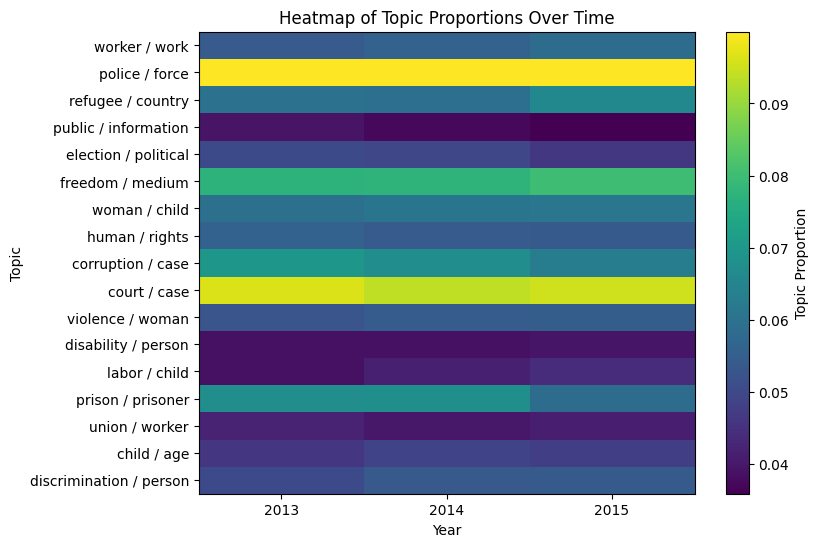

In [27]:
# Topic Proportions

plt.figure(figsize=(8, 6))
plt.imshow(yearly_topics.T, aspect="auto")

plt.colorbar(label="Topic Proportion")
plt.yticks(
    range(len(yearly_topics.columns)),
    [topic_labels_auto[t] for t in yearly_topics.columns]
)
plt.xticks(
    range(len(yearly_topics.index)),
    yearly_topics.index
)

plt.xlabel("Year")
plt.ylabel("Topic")
plt.title("Heatmap of Topic Proportions Over Time")
plt.show()

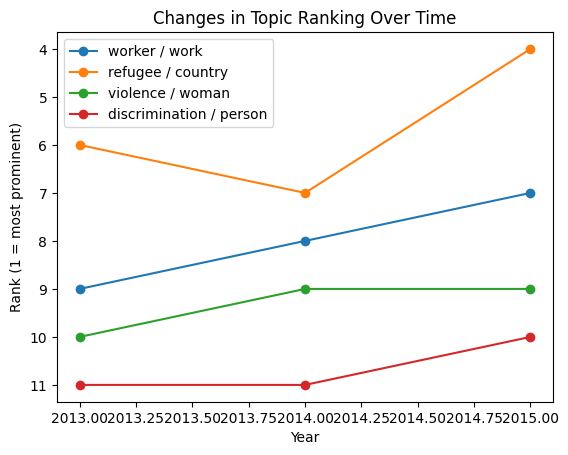

In [28]:
## Topic ranking

ranked = yearly_topics.rank(axis=1, ascending=False)

plt.figure()
for t in [0, 2, 10, 16]: 
    plt.plot(
        ranked.index,
        ranked[t],
        marker="o",
        label=topic_labels_auto[t]
    )

plt.gca().invert_yaxis()
plt.xlabel("Year")
plt.ylabel("Rank (1 = most prominent)")
plt.title("Changes in Topic Ranking Over Time")
plt.legend()
plt.show()

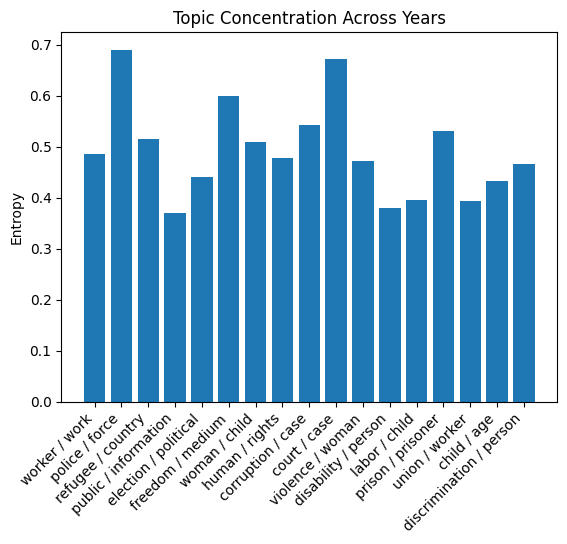

In [29]:
# Topic Concentration
topic_entropy = -(yearly_topics * np.log(yearly_topics + 1e-10)).sum()

plt.figure()
plt.bar(
    [topic_labels_auto[t] for t in topic_entropy.index],
    topic_entropy.values
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Entropy")
plt.title("Topic Concentration Across Years")
plt.show()

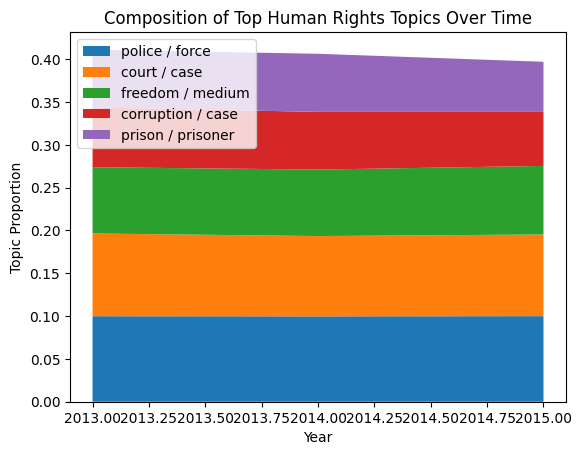

In [30]:
# Composition of Top Human Rights Topics Over Time
top_topics = yearly_topics.mean().sort_values(ascending=False).head(5).index

plt.figure()
plt.stackplot(
    yearly_topics.index,
    [yearly_topics[t] for t in top_topics],
    labels=[topic_labels_auto[t] for t in top_topics]
)

plt.legend(loc="upper left")
plt.xlabel("Year")
plt.ylabel("Topic Proportion")
plt.title("Composition of Top Human Rights Topics Over Time")
plt.show()

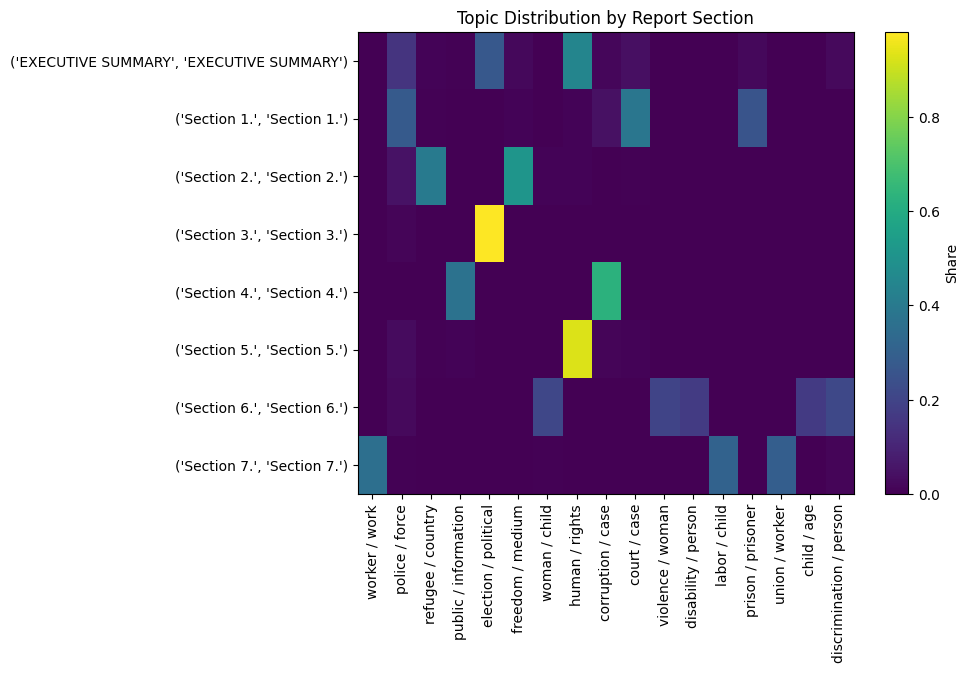

In [31]:
# Topic Distributio
section_topic = (
    df[df["topic"] != -1]
    .groupby(["section", "topic"])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum())
    .unstack(fill_value=0)
)

plt.figure(figsize=(8, 6))
plt.imshow(section_topic, aspect="auto")
plt.colorbar(label="Share")

plt.xticks(
    range(len(section_topic.columns)),
    [topic_labels_auto[t] for t in section_topic.columns],
    rotation=90
)
plt.yticks(range(len(section_topic.index)), section_topic.index)

plt.title("Topic Distribution by Report Section")
plt.show()